# Libraries

In [3]:
import sys
import pandas as pd
sys.path.insert(0, '.')
from utils import calculate_best_epochs, select_values, cumulative_sum, process_model_data, calculate_metrics, update_metrics, process_lines
from math import sqrt
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import iqr
from sklearn.metrics import roc_curve
import seaborn as sns

plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['figure.dpi'] = 100

# Data layout

**data**: all of the data needed for the plots is included in the folder **data**.

- **learning**: learning metrics data (acc and accuracy over epochs).

    - **loss**: training and validation loss data.

        - **train**: training loss data.

            - **GregNet.txt**: training loss of GregNet.
            - **GWaveNet.txt**: training loss of GWaveNet.

        - **val**: validation loss data.

            - **GregNet.txt**: validation loss of GregNet.
            - **GWaveNet.txt**: validation loss of GWaveNet.

    - **accuracy**: training and validation accuracy data.

        - **train**: training accuracy data.

            - **GregNet.txt**: training accuracy of GregNet.
            - **GWaveNet.txt**: training accuracy of GWaveNet.

        - **val**: validation accuracy data.

            - **GregNet.txt**: validation accuracy of GregNet.
            - **GWaveNet.txt**: validation accuracy of GWaveNet.

- **flops**

    - **GregNet.txt**: text file with the number of floating point operations and training loss of GregNet.
    - **GWaveNet.txt**: text file with the number of floating point operations and training loss of GWaveNet.

- **probabilities**

    - **GregNet.txt**: text file that includes 3 columns, separated by ": ", in 5 stages, separated by a line with "Folder {i}" where i goes from 0 to 4.
        - *Column 1*: ground truth class.
        - *Column 2*: probability predicted by GregNet.
        - *Column 3*: PISNR of the sample.
    - **GWaveNet.txt**: text file that includes 3 columns, separated by ": ", in 5 stages, separated by a line with "Folder {i}" where i goes from 0 to 4.
        - *Column 1*: ground truth class.
        - *Column 2*: probability predicted by GWaveNet.
        - *Column 3*: PISNR of the sample.

In [4]:
n_folders = 5
n_samples_train = 8000
n_samples_val = 1000

filename_probabilities_GregNet = "data/probabilities/GregNet.txt"
filename_probabilities_GWaveNet = "data/probabilities/GWaveNet.txt"
filename_learning_loss_train_GregNet = "data/learning/loss/train/GregNet.txt"
filename_learning_loss_val_GregNet = "data/learning/loss/val/GregNet.txt"
filename_learning_loss_train_GWaveNet = "data/learning/loss/train/GWaveNet.txt"
filename_learning_loss_val_GWaveNet = "data/learning/loss/val/GWaveNet.txt"
filename_learning_acc_train_GregNet = "data/learning/acc/train/GregNet.txt"
filename_learning_acc_val_GregNet = "data/learning/acc/val/GregNet.txt"
filename_learning_acc_train_GWaveNet = "data/learning/acc/train/GWaveNet.txt"
filename_learning_acc_val_GWaveNet = "data/learning/acc/val/GWaveNet.txt"
filename_flops_GregNet = "data/flops/GregNet.txt"
filename_flops_GWaveNet = "data/flops/GWaveNet.txt"

# Data plots

**Figure 3.3**: Distribution of PISNR of the test subset for each of the data sets:

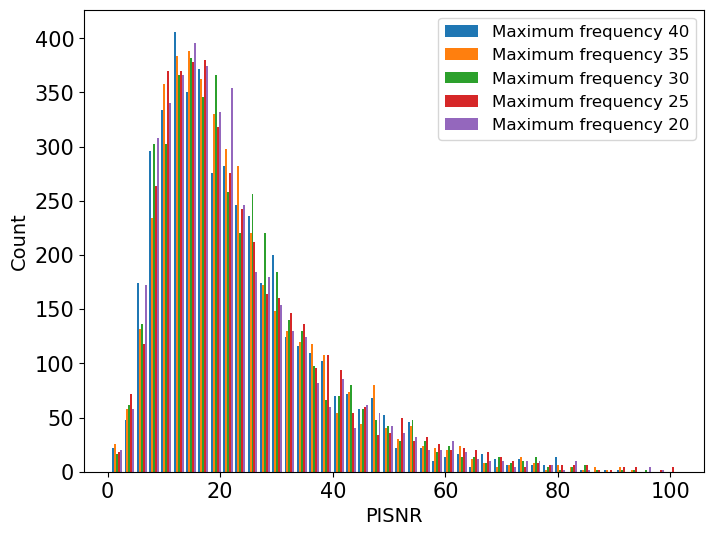

In [5]:
# irrelevant which model is used for this plot, since it only takes the PISNR stats

with open(filename_probabilities_GregNet, "r") as f:
    lines = f.readlines()

pisnr = []
tmp_pisnr = []

for line in lines:
    if "Folder" in line:
        if tmp_pisnr:
            pisnr.append(tmp_pisnr)
            tmp_pisnr = []
    else:
        tmp_pisnr.append(float(line.split(": ")[2]))

pisnr.append(tmp_pisnr)

h = []
n_bins = []

for i in range(len(pisnr)):
    h.append(2 * iqr(pisnr[i]) / (len(pisnr[i]) ** (1 / 3)))
    n_bins.append(int((max(pisnr[i]) - min(pisnr[i])) / h[i]))

plt.hist([pisnr[i] for i in range(len(pisnr))], bins = int(np.mean(n_bins)), label=["Maximum frequency 40", "Maximum frequency 35", "Maximum frequency 30", "Maximum frequency 25", "Maximum frequency 20"])
plt.xlabel("PISNR")
plt.ylabel("Count")
plt.legend(loc="best")
plt.show()

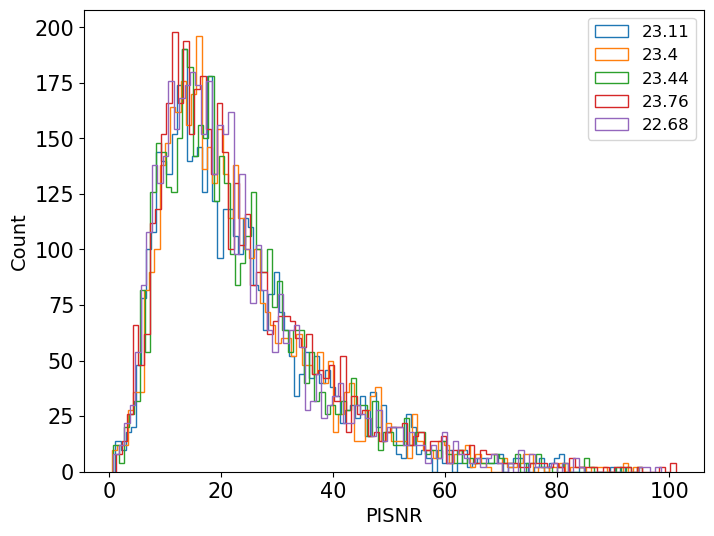

In [6]:
# irrelevant which model is used for this plot, since it only takes the PISNR stats

with open(filename_probabilities_GregNet, "r") as f:
    lines = f.readlines()

pisnr = []
tmp_pisnr = []

for line in lines:
    if "Folder" in line:
        if tmp_pisnr:
            pisnr.append(tmp_pisnr)
            tmp_pisnr = []
    else:
        tmp_pisnr.append(float(line.split(": ")[2]))

pisnr.append(tmp_pisnr)

h = []
n_bins = []

for i in range(len(pisnr)):
    h.append(2 * iqr(pisnr[i]) / (len(pisnr[i]) ** (1 / 3)))
    n_bins.append(int((max(pisnr[i]) - min(pisnr[i])) / h[i]))

i = 0 
for i in range(len(pisnr)):
    plt.hist(pisnr[i], histtype='step', bins=100, label=np.round(np.mean(pisnr[i]), 2))

plt.xlabel("PISNR")
plt.ylabel("Count")
plt.legend(loc="best")
plt.show()

**Figure 4.1**: Training and validation losses over number of epochs for (a) GregNet and (b) GWaveNet, with the corresponding 3σ error for each. The burgundy dashed lines signal the end of a curriculum learning stage, with more data from a new data set being added after them. The solid brown short lines signal the best-performing epoch in each stage.

**Figure 4.2**: Training and validation accuracies over number of epochs for (a) GregNet and (b) GWaveNet, with the corresponding 3σ error for each. The burgundy dashed lines signal the end of a curriculum learning stage, with more data from a new data set being added after them. The solid brown short lines signal the best-performing epoch in each stage.

[6, 12, 18, 24, 30] ok
[7, 13, 25, 35, 49] ok
None


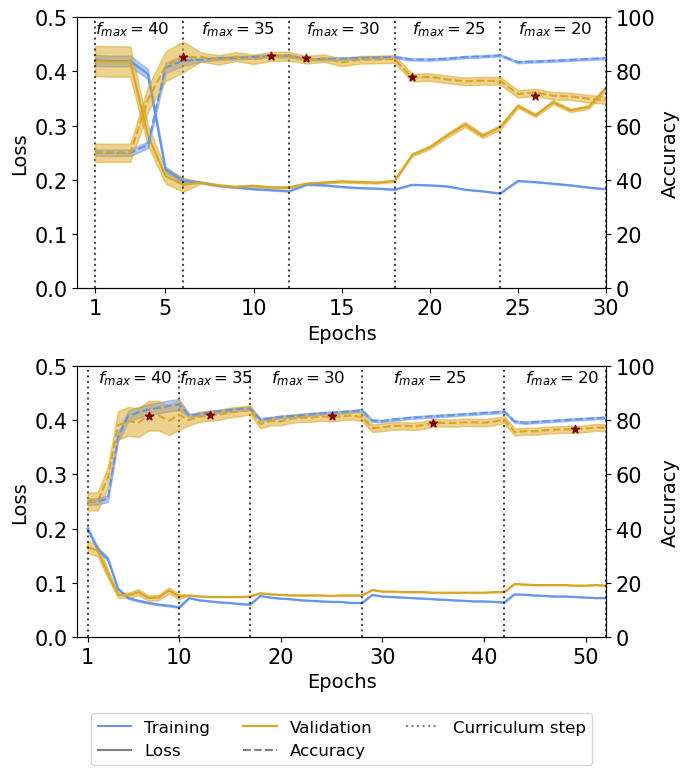

In [7]:
GregNet = process_model_data('GregNet', n_folders, n_samples_train, n_samples_val, 
                       filename_learning_loss_train_GregNet, filename_learning_loss_val_GregNet, 
                       filename_learning_acc_train_GregNet, filename_learning_acc_val_GregNet)

print(cumulative_sum(GregNet['n_epochs']), 'ok')
GWaveNet = process_model_data('GWaveNet', n_folders, n_samples_train, n_samples_val, 
                       filename_learning_loss_train_GWaveNet, filename_learning_loss_val_GWaveNet, 
                       filename_learning_acc_train_GWaveNet, filename_learning_acc_val_GWaveNet)

best_epochs_calculated = calculate_best_epochs(GWaveNet['n_epochs'], GWaveNet['best_epoch'])

print(best_epochs_calculated, 'ok')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 8))

# First subplot for training metrics
ax1.plot(np.arange(np.sum(GregNet['n_epochs']))+1,
         GregNet['train_loss'], 'cornflowerblue', label='Training', zorder=5)
ax1.plot(np.arange(np.sum(GregNet['n_epochs']))+1,
         GregNet['val_loss'], 'goldenrod', label='Validation', zorder=5)
ax1.fill_between(x = np.arange(np.sum(GregNet['n_epochs']))+1,
                 y1 = np.asarray(GregNet['train_loss']) +np.asarray(GregNet['shaded_loss_train']),
                 y2 = np.asarray(GregNet['train_loss']) -np.asarray(GregNet['shaded_loss_train']),
                 alpha = 0.5, color='cornflowerblue')
ax1.fill_between(x = np.arange(np.sum(GregNet['n_epochs']))+1,
                 y1 = np.asarray(GregNet['val_loss']) + np.asarray(GregNet['shaded_loss_val']),
                 y2 = np.asarray(GregNet['val_loss']) - np.asarray(GregNet['shaded_loss_val']),
                 alpha = 0.5, color='goldenrod')
ax1.text(1, 0.47, r'$f_{max} = 40$', fontsize=12)
ax1.text(7, 0.47, r'$f_{max} = 35$', fontsize=12)
ax1.text(13, 0.47, r'$f_{max} = 30$', fontsize=12)
ax1.text(19, 0.47, r'$f_{max} = 25$', fontsize=12)
ax1.text(25, 0.47, r'$f_{max} = 20$', fontsize=12)


ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_ylim(0, 0.5)
ax1_twin = ax1.twinx()
print(cumulative_sum(GregNet['n_epochs']).extend([1]))
ax1_twin.vlines(x=[1] + cumulative_sum(GregNet['n_epochs']),
                ymin=0, ymax=100, color='black', zorder=1, alpha=0.7, linestyle='dotted')
ax1_twin.plot(np.arange(np.sum(GregNet['n_epochs']))+1,
              GregNet['train_acc'], 'cornflowerblue', label='Training Loss', linestyle='--', zorder=5)
ax1_twin.plot(np.arange(np.sum(GregNet['n_epochs']))+1,
              GregNet['val_acc'], 'goldenrod', label='Validation Loss', linestyle='--', zorder=5)
ax1_twin.fill_between(x = np.arange(np.sum(GregNet['n_epochs']))+1,
                 y1 = np.asarray(GregNet['train_acc']) +np.asarray(GregNet['shaded_acc_train']),
                 y2 = np.asarray(GregNet['train_acc']) -np.asarray(GregNet['shaded_acc_train']),
                      alpha = 0.5, color='cornflowerblue')
ax1_twin.fill_between(x = np.arange(np.sum(GregNet['n_epochs']))+1,
                 y1 = np.asarray(GregNet['val_acc']) +np.asarray(GregNet['shaded_acc_val']),
                 y2 = np.asarray(GregNet['val_acc']) -np.asarray(GregNet['shaded_acc_val']),
                      alpha = 0.5, color='goldenrod')

ax1_twin.set_ylabel('Accuracy')
ax1_twin.scatter(GregNet['n_epochs'] * np.arange(5) + GregNet['best_epoch'],
                 select_values(GregNet['val_acc'], GregNet['n_epochs'] * np.arange(5) + GregNet['best_epoch']),
                 zorder=10, marker='*', c='maroon')

ax1_twin.set_ylim(0, 100)
ax1_twin.set_xlim(0, np.sum(GregNet['n_epochs']))
ax1.set_xticks([1, 5, 10, 15, 20, 25, 30])

fig.tight_layout()

# Second subplot for validation metrics
ax2.plot(np.arange(np.sum(GWaveNet['n_epochs']))+1,
         GWaveNet['train_loss'], 'cornflowerblue', label='Training', zorder=5)
ax2.plot(np.arange(np.sum(GWaveNet['n_epochs']))+1,
         GWaveNet['val_loss'], 'goldenrod', label='Validation', zorder=5)
ax2.fill_between(x = np.arange(np.sum(GWaveNet['n_epochs']))+1,
                 y1 = np.asarray(GWaveNet['train_loss']) +np.asarray(GWaveNet['shaded_loss_train']),
                 y2 = np.asarray(GWaveNet['train_loss']) -np.asarray(GWaveNet['shaded_loss_train']),
                      alpha = 0.5, color='cornflowerblue')
ax2.fill_between(x = np.arange(np.sum(GWaveNet['n_epochs']))+1,
                 y1 = np.asarray(GWaveNet['val_loss']) +np.asarray(GWaveNet['shaded_loss_val']),
                 y2 = np.asarray(GWaveNet['val_loss']) -np.asarray(GWaveNet['shaded_loss_val']),
                      alpha = 0.5, color='goldenrod')
ax2.text(2, 0.47, r'$f_{max} = 40$', fontsize=12)
ax2.text(10, 0.47, r'$f_{max} = 35$', fontsize=12)
ax2.text(19, 0.47, r'$f_{max} = 30$', fontsize=12)
ax2.text(31, 0.47, r'$f_{max} = 25$', fontsize=12)
ax2.text(44, 0.47, r'$f_{max} = 20$', fontsize=12)
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.set_ylim(0, 0.5)

ax2_twin = ax2.twinx()
ax2_twin.vlines(x=[1] + cumulative_sum(GWaveNet['n_epochs']), ymin=0, ymax=100, color='black', zorder=1, alpha=0.7, linestyle='dotted')

ax2_twin.plot(np.arange(np.sum(GWaveNet['n_epochs']))+1,
              GWaveNet['train_acc'], 'cornflowerblue', label='Training Loss', linestyle='--', zorder=5)
ax2_twin.plot(np.arange(np.sum(GWaveNet['n_epochs']))+1,
              GWaveNet['val_acc'], 'goldenrod', label='Validation Loss', linestyle='--', zorder=5)
ax2_twin.fill_between(x = np.arange(np.sum(GWaveNet['n_epochs']))+1,
                 y1 = np.asarray(GWaveNet['train_acc']) +np.asarray(GWaveNet['shaded_acc_train']),
                 y2 = np.asarray(GWaveNet['train_acc']) -np.asarray(GWaveNet['shaded_acc_train']),
                      alpha = 0.5, color='cornflowerblue')
ax2_twin.fill_between(x = np.arange(np.sum(GWaveNet['n_epochs']))+1,
                 y1 = np.asarray(GWaveNet['val_acc']) +np.asarray(GWaveNet['shaded_acc_val']),
                 y2 = np.asarray(GWaveNet['val_acc']) -np.asarray(GWaveNet['shaded_acc_val']),
                      alpha = 0.5, color='goldenrod')

ax2_twin.scatter(best_epochs_calculated,
                 select_values(GWaveNet['val_acc'],best_epochs_calculated),
                 zorder=10, marker='*', c='maroon')

ax2_twin.set_ylabel('Accuracy')
ax2_twin.set_ylim(0, 100)
ax2_twin.set_xlim(0, np.sum(GWaveNet['n_epochs']))
ax2.set_xticks([1, 10, 20, 30, 40, 50])

# Create legend for solid and dashed lines
train_line = plt.Line2D([], [], color='cornflowerblue', linestyle='-', label='Training')
val_line = plt.Line2D([], [], color='goldenrod', linestyle='-', label='Validation')
solid_line = plt.Line2D([], [], color='grey', linestyle='-', label='Loss')
dashed_line = plt.Line2D([], [], color='grey', linestyle='--', label='Accuracy')
curriculum_line = plt.Line2D([], [], color='grey', linestyle='dotted', label='Curriculum step')


# Add legend below the second subplot
ax2.legend(handles=[train_line, solid_line, val_line, dashed_line, curriculum_line],
           loc='upper center', bbox_to_anchor=(0.5, -0.25), ncols=3)

fig.tight_layout()
plt.savefig('loss_acc.pdf')
plt.show()

# plt.fill_between(x = np.arange(1, n_epochs[-1] + 1), y1 = [train_loss[i] - shaded_loss_train[i] for i in range(n_epochs[-1])], y2 = [train_loss[i] + shaded_loss_train[i] for i in range(n_epochs[-1])], alpha = 0.5)
# plt.fill_between(x = np.arange(1, n_epochs[-1] + 1), y1 = [val_loss[i] - shaded_loss_val[i] for i in range(n_epochs[-1])], y2 = [val_loss[i] + shaded_loss_val[i] for i in range(n_epochs[-1])], alpha = 0.5)
# plt.plot(np.arange(1, n_epochs[-1] + 1), train_loss, label="Training loss")
# plt.plot(np.arange(1, n_epochs[-1] + 1), val_loss, label="Validation loss")
# plt.vlines(x = n_epochs, ymin = 0, ymax = 0.5)
# plt.vlines(x = best_epoch, ymin = [min([train_loss[b], val_loss[b]])  - 0.01 for b in best_epoch], ymax = [max([train_loss[b], val_loss[b]]) + 0.01 for b in best_epoch])

# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.legend(loc="best")
# plt.show()

**Figure 4.3**: Training losses over number of FLOPs for GregNet (cream) and GWaveNet (orange). We present the average loss per epoch for the cumulative amount of FLOPs and the corresponding 3σ error. The vertical axis is in logarithmic scale.

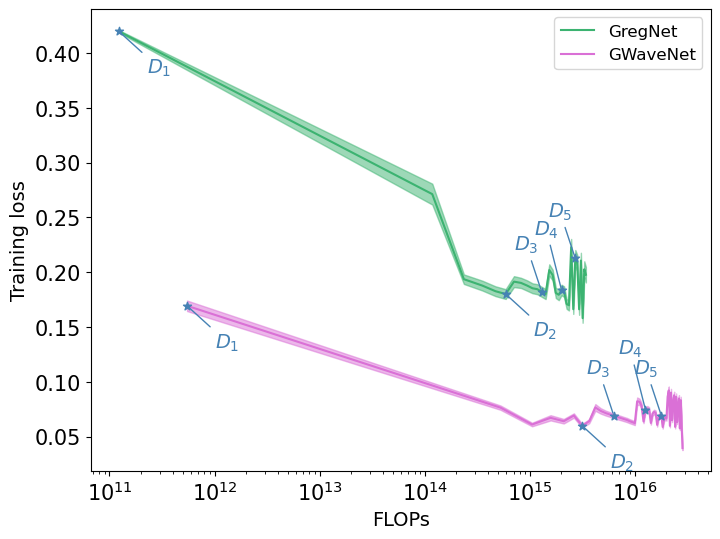

In [55]:
filenames = [filename_flops_GregNet, filename_flops_GWaveNet]
colors = ['mediumseagreen', 'orchid']
labels = ["GregNet", "GWaveNet"]

for filename, color in zip(filenames, colors):
    if filename == filenames[0]: best_list = cumulative_sum(GregNet['n_epochs'])
    if filename == filenames[1]: best_list = best_epochs_calculated
    with open(filename, "r") as f:
        lines = f.readlines()

    flops = lines[0].split("], [")[0][1:]
    loss = lines[0].split("], [")[1][:-2]

    flops = flops.split(", ")
    loss = loss.split(", ")

    flops = [float(flop) for flop in flops]
    loss = [float(l) for l in loss]

    # for every 960 data points, save the last flop and average out the loss
    flops_avg = []
    loss_avg = []
    loss_std = []


    best_flops, best_loss = [], []
    for c, i in enumerate(range(0, len(flops), 960)):
        if c == 0:
            best_flops.append(flops[i])
            best_loss.append(sum(loss[i:i+960])/960)
        flops_avg.append(flops[i])
        loss_avg.append(sum(loss[i:i+960])/960)
        loss_std.append(np.std(loss[i:i+960]))
        if (c+1) in best_list:
            best_flops.append(flops[i])
            best_loss.append(sum(loss[i:i+960])/960)
    
    plt.fill_between(flops_avg, [loss_avg[i] - 3 * loss_std[i]/sqrt(960) for i in range(len(loss_avg))], [loss_avg[i] + 3*loss_std[i]/sqrt(960) for i in range(len(loss_avg))], alpha = 0.5, color=color)
    plt.plot(flops_avg, loss_avg, label=labels[filenames.index(filename)], color=color)
    annotations = [
    {"xytext": (20, -30)},  # For point 1
    {"xytext": (20, -30)}, # For point 2
    {"xytext": (-20, 30)}, # For point 3
    {"xytext": (-20, 40)},# For point 4
    {"xytext": (-20, 30)},  # For point 5
    ]
    for j in range(len(best_list)):
        plt.annotate(f'$D_{{{j+1}}}$',  # Label text
                     (best_flops[j], best_loss[j]),  # Point location
                     textcoords="offset points",  # Offset for the label
                     **annotations[j],  # Position of the text
                     arrowprops=dict(arrowstyle="-", color='steelblue'), color='steelblue', fontsize=14)  # Arrow style

        plt.scatter(best_flops[j], best_loss[j],zorder=10, color='steelblue',marker='*')
    
plt.xlabel("FLOPs")
plt.ylabel("Training loss")
plt.legend(loc="best")
plt.xscale("log")
plt.savefig("loss_flops.pdf")
plt.show()

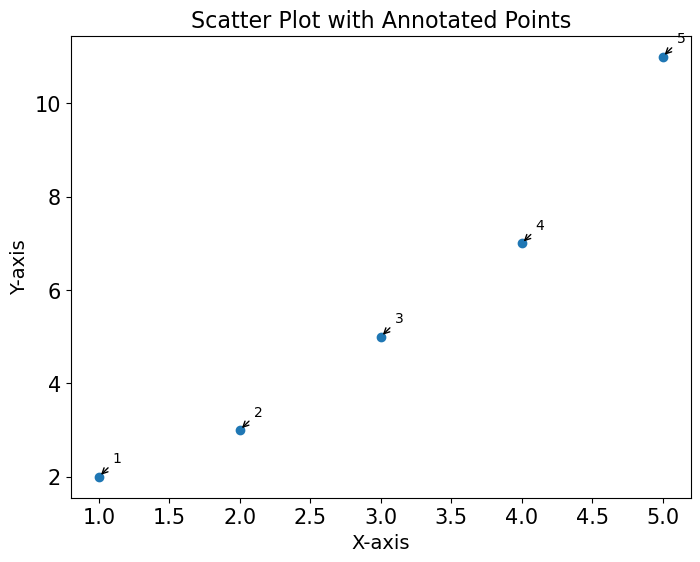

In [19]:
import matplotlib.pyplot as plt

# Sample data for the scatter plot
x = [1, 2, 3, 4, 5]
y = [2, 3, 5, 7, 11]

# Create the scatter plot
plt.scatter(x, y)

# Add arrows and labels
for i in range(len(x)):
    plt.annotate(str(i+1),  # Label text
                 (x[i], y[i]),  # Point location
                 textcoords="offset points",  # Offset for the label
                 xytext=(10, 10),  # Position of the text
                 arrowprops=dict(arrowstyle="->", color='black'))  # Arrow style

# Display the plot
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Scatter Plot with Annotated Points')
plt.show()

In [14]:
tmp = cumulative_sum(GregNet['n_epochs'])
for i in range(30):
    if i in tmp:
        print(i)

6
12
18
24


**Figure 4.4**: Probability distribution for both noise and signal classes for (a) GregNet and (b) GWaveNet.

/tmp/ipykernel_907711/1536375697.py:35: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 4000)


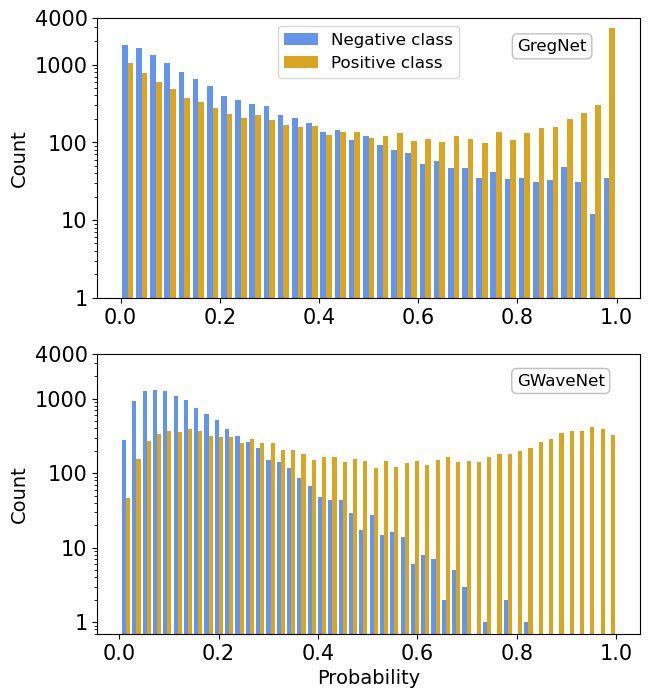

In [18]:
# change here for which model to plot the probabilities for
model = "GWaveNet"
fig, axs = plt.subplots(2, 1, figsize=(7, 8))

for model, ax in zip(["GregNet", "GWaveNet"], axs):
    if model == "GregNet":
        filename_probabilities = filename_probabilities_GregNet
    elif model == "GWaveNet":
        filename_probabilities = filename_probabilities_GWaveNet
    
    with open(filename_probabilities, "r") as f:
        lines = f.readlines()
    
    negative_class = []
    positive_class = []
    
    for line in lines:
        if "Folder" not in line:
            if float(line.split(": ")[0]) == 0:
                negative_class.append(float(line.split(": ")[1]))
            elif float(line.split(": ")[0]) == 1:
                positive_class.append(float(line.split(": ")[1]))
    
    h_negative = 2 * iqr(negative_class) / (len(negative_class) ** (1 / 3))
    h_positive = 2 * iqr(positive_class) / (len(positive_class) ** (1 / 3))
    
    n_bins_negative = int((max(negative_class) - min(negative_class)) / h_negative)
    n_bins_positive = int((max(positive_class) - min(positive_class)) / h_positive)
    
    ax.hist([negative_class, positive_class], 
            bins = int(np.mean([n_bins_negative, n_bins_positive])), label=["Negative class", "Positive class"], color=['cornflowerblue', 'goldenrod'])
    ax.set_yscale('log')
    ax.set_ylabel("Count")
    ax.set_yticks([1, 10, 100, 1000, 4000], [1, 10, 100, 1000, 4000])
    ax.set_ylim(0, 4000)
plt.xlabel("Probability")
axs[0].legend(loc="best")
axs[0].text(0.8, 1500, 'GregNet', bbox=dict(facecolor='none', edgecolor='silver', boxstyle='round'), fontsize=12)
axs[1].text(0.8, 1500, 'GWaveNet', bbox=dict(facecolor='none', edgecolor='silver', boxstyle='round'), fontsize=12)
plt.savefig('class_probability.pdf')
plt.show()


**Figure 4.7**: FAP over the decision threshold for GregNet (yellow) and GWaveNet (orange). The burgundy dashed line represents the FAP at 1%, and it intercepts the curves at 0.86 and 0.46 respectively.

In [24]:
np.arange(0, 1.01, 0.01)

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  ])

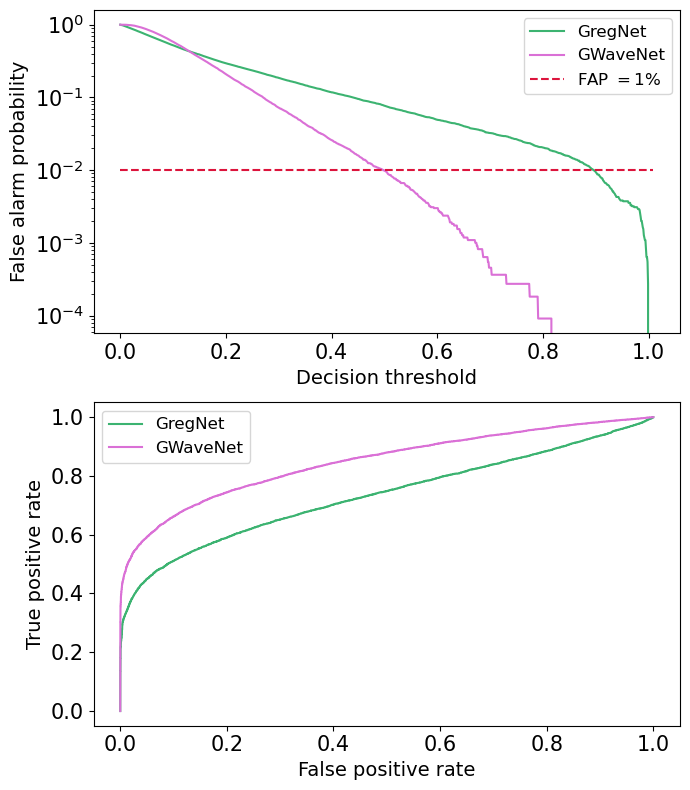

In [34]:
filenames = [filename_probabilities_GregNet, filename_probabilities_GWaveNet]
decision_thresholds = np.arange(0, 1.01, 0.001)
fig, axs = plt.subplots(2, 1, figsize=(7, 8))
for filename, color in zip(filenames, colors):
    with open(filename, "r") as f:
        lines = f.readlines()

    true_y = []
    pred_y = []

    for line in lines:
        if "Folder" not in line:
            true_y.append(int(float(line.split(": ")[0])))
            pred_y.append(float(line.split(": ")[1]))

    fap = []
    for decision_threshold in decision_thresholds:
        fp = 0
        tn = 0
        for i in range(len(true_y)):
            if true_y[i] == 0:
                if pred_y[i] >= decision_threshold:
                    fp += 1
                else:
                    tn += 1
        
        fap.append(fp / (fp + tn))
    
    axs[0].plot(decision_thresholds, fap, label=filename.split("/")[2].split(".")[0], color=color)

axs[0].plot(decision_thresholds, [0.01] * len(decision_thresholds), linestyle='--', c='crimson', label=r'FAP $=1\%$')
axs[0].set_yscale('log')
axs[0].set_xlabel("Decision threshold")
axs[0].set_ylabel("False alarm probability")
axs[0].legend(loc="best")


filenames = [filename_probabilities_GregNet, filename_probabilities_GWaveNet]


for filename, color in zip(filenames, colors):
    with open(filename, "r") as f:
        lines = f.readlines()

    true_y = []
    pred_y = []

    for line in lines:
        if "Folder" not in line:
            true_y.append(int(float(line.split(": ")[0])))
            pred_y.append(float(line.split(": ")[1]))

    fpr, tpr, _ = roc_curve(true_y, pred_y)

    axs[1].plot(fpr, tpr, label=filename.split("/")[2].split(".")[0], color=color)

axs[1].set_xlabel("False positive rate")
axs[1].set_ylabel("True positive rate")
axs[1].legend(loc="best")
plt.tight_layout()
plt.savefig('fap_comparison_roc_curve.pdf')



**Figure 4.8**: ROC curve for GregNet and GWaveNet.

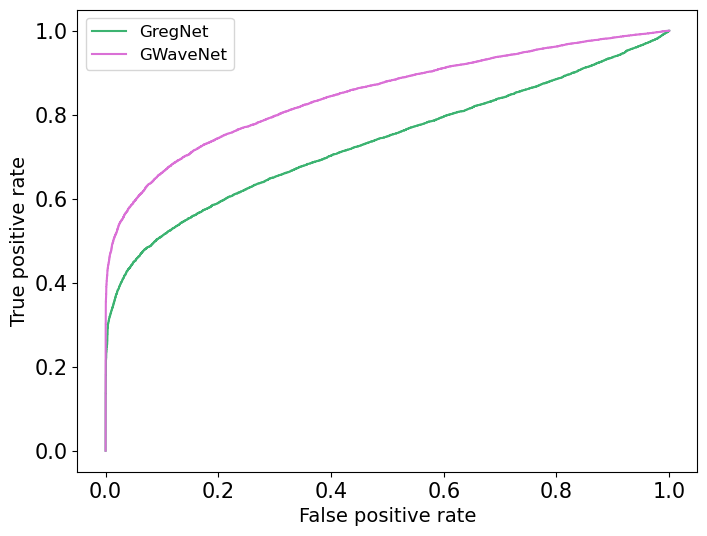

In [20]:
filenames = [filename_probabilities_GregNet, filename_probabilities_GWaveNet]

fig= plt.figure(figsize=(8, 6))
for filename, color in zip(filenames, colors):
    with open(filename, "r") as f:
        lines = f.readlines()

    true_y = []
    pred_y = []

    for line in lines:
        if "Folder" not in line:
            true_y.append(int(float(line.split(": ")[0])))
            pred_y.append(float(line.split(": ")[1]))

    fpr, tpr, _ = roc_curve(true_y, pred_y)

    plt.plot(fpr, tpr, label=filename.split("/")[2].split(".")[0], color=color)

plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.legend(loc="best")
plt.savefig('roc_curve.pdf')
plt.show()

**Figure 4.9**: TAP over the PISNR for the different data sets for (a) GregNet and (b) GWaveNet, for a set FAP of 1%.

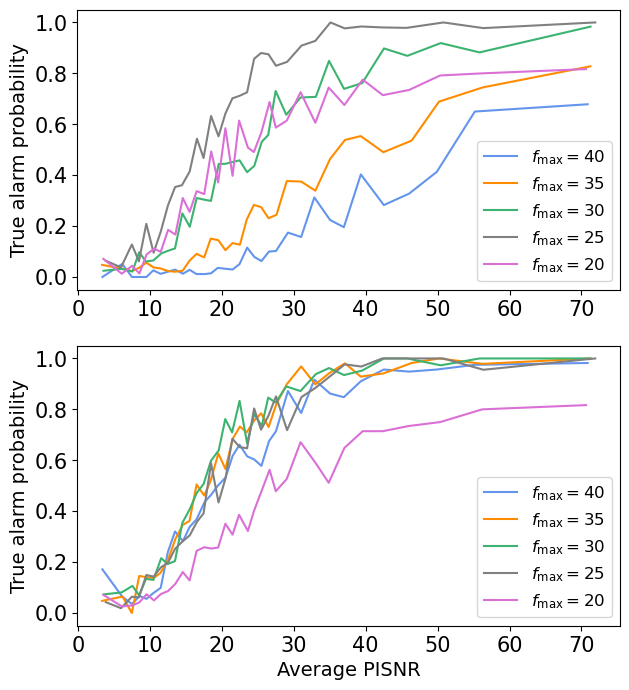

In [15]:
colors = ['cornflowerblue', 'darkorange', 'mediumseagreen', 'grey', 'orchid']
fig, axs = plt.subplots(2, 1, figsize=(7, 8))
cases = [5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 32, 34, 36, 38, 41, 44, 48, 53, 60]

for model, ax in zip(["GregNet", "GWaveNet"], axs):
    if model == "GregNet":
        filename_probabilities = filename_probabilities_GregNet
        decision_threshold = 0.86
    else:
        filename_probabilities = filename_probabilities_GWaveNet
        decision_threshold = 0.46
    
    with open(filename_probabilities, "r") as f:
        lines = f.readlines()
    
    true_y, pred_y, pisnr = process_lines(lines, decision_threshold)
    n_folders = len(true_y)
    avg_pisnr, tp, fn = update_metrics(true_y, pred_y, pisnr, cases)

    for i, color in zip(range(n_folders), colors):
        x, y = calculate_metrics([avg_pisnr[i]], [tp[i]], [fn[i]], cases)
        ax.plot(x, y, label=f"$f_{{\\max}}={40 - 5 * i}$", color=color)
    
    ax.legend(loc="best", fontsize=12)
    ax.set_ylabel("True alarm probability")

plt.xlabel("Average PISNR")
plt.savefig('probability_pisnr.pdf')
plt.show()



In [53]:
data_all = pd.read_csv('data/params.csv')

for i in range(5):
    data_set = data_all[20000*i:20000*(i+1)]
    print(i, np.mean(data_set['netSnr']), np.mean(data_set['netPIsnr']))

0 100.29856317623693 34.484990520351516
1 127.18283850842523 34.19789016964992
2 186.48919283516335 34.70380837402367
3 344.6232305447391 34.65342722014478
4 1161.385255727974 34.619898952352735
